**推論ベース**\
コンテキストから注目する単語(ターゲット)を推論する\
モデルを考える。コンテキスト情報を入力、各単語の出現する確率を出力\

In [1]:
#import系#
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss
from common.util import preprocess, create_contexts_target, convert_one_hot
from common.trainer import Trainer
from common.optimizer import Adam

In [2]:
C = np.array([[1, 0, 0, 0, 0, 0, 0]]) #入力(コンテキスト情報) one-hot表現
W = np.random.randn(7, 3)
h = np.dot(C, W) #中間ノード
print(h)

[[ 0.73372415 -0.62363838 -0.29934618]]


In [3]:
C = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
layer = MatMul(W)
h = layer.forward(C) #順伝播
print(h)

[[ 1.1505602  -0.22336238  0.5328723 ]]


行列の積による計算で実装できる。MatMulレイヤでも可能

word2vecでは\
continuous bag-of-words (CBOW) モデル\
が提案\
CBOWモデルでの推論処理\
中間層では入力層からの出力の平均をとる。入力層から中間層への変換時の重みが単語の分散表現にあたる。中間層から出力層への変換時の重みも単語の分散表現であるが、一般的に入力側のみを用いる。


In [4]:
# サンプルのコンテキストデータ
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 重みの初期化
W_in = np.random.randn(7, 3) #encode
W_out = np.random.randn(3, 7) #decode

# layerの作成
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

#順伝播
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1) #平均
s = out_layer.forward(h)

print(s) #score


[[ 0.58710322 -1.03994393 -0.05756576 -1.05514319 -0.75414982  2.87057288
   0.03000171]]


ここで得たscoreはsoftmaxレイヤを通すことで確率となり、正解ラベルが求められる。\
学習のためにCross Emtropy Errorレイヤを通し、損失関数を求める。したがってSoftmax with Lossレイヤを用いる。\
両端を除くコーパス内の単語全てをターゲットと考え、それに対応するコンテキストを抜き出す。このコンテキストの各行が入力となり、ターゲットが正解ラベルにあたる。


In [5]:
# コーパスの準備
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(corpus.shape) #(8,)
print(id_to_word)
print(word_to_id)

[0 1 2 3 4 1 5 6]
(8,)
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}


In [6]:
# コーパスからコンテキスト、ターゲット抽出
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size: -window_size]
    contexts = []
    for idx in range(window_size, len(corpus) - window_size ):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
    return np.array(contexts), np.array(target)

In [7]:
# コーパスからコンテキスト、ターゲット抽出 実行
contexts , target = create_contexts_target(corpus, window_size=1)

print(contexts) #単語ID
print(target) #単語ID

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


In [8]:
# one-hot表現への変換
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size) #変換
contexts = convert_one_hot(contexts, vocab_size) #変換

print(contexts) #one-hot表現
print()
print(target) #one-hot表現

[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]


CBOWモデルの実装\

In [9]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size # 7, 5
        
        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f') # (7, 5)
        W_out = 0.01 * np.random.randn(H, V).astype('f') # (5, 7)
        
        # layerの作成
        self.in_layer0 = MatMul(W_in) # (7, 5)
        self.in_layer1 = MatMul(W_in) # (7, 5)
        self.out_layer = MatMul(W_out) #(5, 7)
        self.loss_layer = SoftmaxWithLoss()
        
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        #メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in
        
    # 順伝播
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0]) # MatMul
        h1 = self.in_layer1.forward(contexts[:, 1]) # MatMul
        h = (h0 + h1) * 0.5 # 平均
        score = self.out_layer.forward(h) # MatMul
        loss = self.loss_layer.forward(score, target) #Softmax() & Cross Emtropy Loss
        return loss
    
    # 逆伝播
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer0.backward(da)
        self.in_layer1.backward(da)
        return None
    

7
| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | 

| epoch 176 |  iter 1 / 2 | time 0[s] | loss 1.30
| epoch 177 |  iter 1 / 2 | time 0[s] | loss 1.38
| epoch 178 |  iter 1 / 2 | time 0[s] | loss 1.29
| epoch 179 |  iter 1 / 2 | time 0[s] | loss 1.35
| epoch 180 |  iter 1 / 2 | time 0[s] | loss 1.39
| epoch 181 |  iter 1 / 2 | time 0[s] | loss 1.25
| epoch 182 |  iter 1 / 2 | time 0[s] | loss 1.44
| epoch 183 |  iter 1 / 2 | time 0[s] | loss 1.24
| epoch 184 |  iter 1 / 2 | time 0[s] | loss 1.27
| epoch 185 |  iter 1 / 2 | time 0[s] | loss 1.40
| epoch 186 |  iter 1 / 2 | time 0[s] | loss 1.28
| epoch 187 |  iter 1 / 2 | time 0[s] | loss 1.36
| epoch 188 |  iter 1 / 2 | time 0[s] | loss 1.26
| epoch 189 |  iter 1 / 2 | time 0[s] | loss 1.32
| epoch 190 |  iter 1 / 2 | time 0[s] | loss 1.37
| epoch 191 |  iter 1 / 2 | time 0[s] | loss 1.21
| epoch 192 |  iter 1 / 2 | time 0[s] | loss 1.34
| epoch 193 |  iter 1 / 2 | time 0[s] | loss 1.26
| epoch 194 |  iter 1 / 2 | time 0[s] | loss 1.26
| epoch 195 |  iter 1 / 2 | time 0[s] | loss 1.28


| epoch 378 |  iter 1 / 2 | time 0[s] | loss 1.06
| epoch 379 |  iter 1 / 2 | time 0[s] | loss 0.79
| epoch 380 |  iter 1 / 2 | time 0[s] | loss 0.82
| epoch 381 |  iter 1 / 2 | time 0[s] | loss 0.93
| epoch 382 |  iter 1 / 2 | time 0[s] | loss 0.82
| epoch 383 |  iter 1 / 2 | time 0[s] | loss 0.84
| epoch 384 |  iter 1 / 2 | time 0[s] | loss 0.85
| epoch 385 |  iter 1 / 2 | time 0[s] | loss 0.89
| epoch 386 |  iter 1 / 2 | time 0[s] | loss 0.83
| epoch 387 |  iter 1 / 2 | time 0[s] | loss 0.97
| epoch 388 |  iter 1 / 2 | time 0[s] | loss 0.78
| epoch 389 |  iter 1 / 2 | time 0[s] | loss 0.88
| epoch 390 |  iter 1 / 2 | time 0[s] | loss 0.73
| epoch 391 |  iter 1 / 2 | time 0[s] | loss 0.82
| epoch 392 |  iter 1 / 2 | time 0[s] | loss 0.95
| epoch 393 |  iter 1 / 2 | time 0[s] | loss 0.82
| epoch 394 |  iter 1 / 2 | time 0[s] | loss 0.84
| epoch 395 |  iter 1 / 2 | time 0[s] | loss 0.92
| epoch 396 |  iter 1 / 2 | time 0[s] | loss 0.77
| epoch 397 |  iter 1 / 2 | time 0[s] | loss 0.80


| epoch 613 |  iter 1 / 2 | time 0[s] | loss 0.72
| epoch 614 |  iter 1 / 2 | time 0[s] | loss 0.59
| epoch 615 |  iter 1 / 2 | time 0[s] | loss 0.72
| epoch 616 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 617 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 618 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 619 |  iter 1 / 2 | time 0[s] | loss 0.55
| epoch 620 |  iter 1 / 2 | time 0[s] | loss 0.72
| epoch 621 |  iter 1 / 2 | time 0[s] | loss 0.55
| epoch 622 |  iter 1 / 2 | time 0[s] | loss 0.79
| epoch 623 |  iter 1 / 2 | time 0[s] | loss 0.62
| epoch 624 |  iter 1 / 2 | time 0[s] | loss 0.59
| epoch 625 |  iter 1 / 2 | time 0[s] | loss 0.62
| epoch 626 |  iter 1 / 2 | time 0[s] | loss 0.62
| epoch 627 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 628 |  iter 1 / 2 | time 0[s] | loss 0.55
| epoch 629 |  iter 1 / 2 | time 0[s] | loss 0.96
| epoch 630 |  iter 1 / 2 | time 0[s] | loss 0.58
| epoch 631 |  iter 1 / 2 | time 0[s] | loss 0.65
| epoch 632 |  iter 1 / 2 | time 0[s] | loss 0.48


| epoch 778 |  iter 1 / 2 | time 0[s] | loss 0.72
| epoch 779 |  iter 1 / 2 | time 0[s] | loss 0.54
| epoch 780 |  iter 1 / 2 | time 0[s] | loss 0.62
| epoch 781 |  iter 1 / 2 | time 0[s] | loss 0.65
| epoch 782 |  iter 1 / 2 | time 0[s] | loss 0.46
| epoch 783 |  iter 1 / 2 | time 0[s] | loss 0.56
| epoch 784 |  iter 1 / 2 | time 0[s] | loss 0.79
| epoch 785 |  iter 1 / 2 | time 0[s] | loss 0.60
| epoch 786 |  iter 1 / 2 | time 0[s] | loss 0.46
| epoch 787 |  iter 1 / 2 | time 0[s] | loss 0.74
| epoch 788 |  iter 1 / 2 | time 0[s] | loss 0.49
| epoch 789 |  iter 1 / 2 | time 0[s] | loss 0.46
| epoch 790 |  iter 1 / 2 | time 0[s] | loss 0.78
| epoch 791 |  iter 1 / 2 | time 0[s] | loss 0.57
| epoch 792 |  iter 1 / 2 | time 0[s] | loss 0.71
| epoch 793 |  iter 1 / 2 | time 0[s] | loss 0.56
| epoch 794 |  iter 1 / 2 | time 0[s] | loss 0.46
| epoch 795 |  iter 1 / 2 | time 0[s] | loss 0.60
| epoch 796 |  iter 1 / 2 | time 0[s] | loss 0.79
| epoch 797 |  iter 1 / 2 | time 0[s] | loss 0.60


| epoch 951 |  iter 1 / 2 | time 0[s] | loss 0.36
| epoch 952 |  iter 1 / 2 | time 0[s] | loss 0.84
| epoch 953 |  iter 1 / 2 | time 0[s] | loss 0.58
| epoch 954 |  iter 1 / 2 | time 0[s] | loss 0.32
| epoch 955 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 956 |  iter 1 / 2 | time 0[s] | loss 0.53
| epoch 957 |  iter 1 / 2 | time 0[s] | loss 0.84
| epoch 958 |  iter 1 / 2 | time 0[s] | loss 0.25
| epoch 959 |  iter 1 / 2 | time 0[s] | loss 0.90
| epoch 960 |  iter 1 / 2 | time 0[s] | loss 0.36
| epoch 961 |  iter 1 / 2 | time 0[s] | loss 0.64
| epoch 962 |  iter 1 / 2 | time 0[s] | loss 0.46
| epoch 963 |  iter 1 / 2 | time 0[s] | loss 0.83
| epoch 964 |  iter 1 / 2 | time 0[s] | loss 0.36
| epoch 965 |  iter 1 / 2 | time 0[s] | loss 0.53
| epoch 966 |  iter 1 / 2 | time 0[s] | loss 0.72
| epoch 967 |  iter 1 / 2 | time 0[s] | loss 0.43
| epoch 968 |  iter 1 / 2 | time 0[s] | loss 0.77
| epoch 969 |  iter 1 / 2 | time 0[s] | loss 0.38
| epoch 970 |  iter 1 / 2 | time 0[s] | loss 0.83


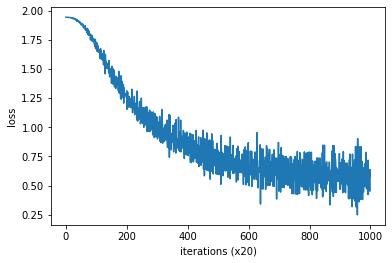

In [10]:
# 学習コードの実装

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
print(vocab_size)
contexts, target = create_contexts_target(corpus, window_size)

target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

損失lossが徐々に減少しているのが確認できる。学習後は入力側の重みW_inが単語の分散表現にあたる。word_vecsに格納してあるので、確認する

In [11]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [-1.1075509 -1.1320995 -1.1965662  1.1707288  1.2083484]
say [ 1.2715461   1.274137    0.29644376 -0.6545986  -1.2329211 ]
goodbye [-0.80182344 -0.7766444  -0.7868192   0.72603106  0.7165854 ]
and [ 0.9792554   0.98187095  1.6267095  -1.5809928  -0.968827  ]
i [-0.8047637  -0.7634318  -0.7754185   0.7255416   0.69620967]
hello [-1.0929999 -1.1342118 -1.1822642  1.1832428  1.2184069]
. [ 1.182457   1.1763518 -1.6312168  1.6227435 -1.1181184]


このように単語の分散表現を得ることができた。\
次にもう少し長いコーパスで実行してみる。

68
| epoch 1 |  iter 1 / 35 | time 0[s] | loss 4.22
| epoch 1 |  iter 21 / 35 | time 0[s] | loss 4.22
| epoch 2 |  iter 1 / 35 | time 0[s] | loss 4.22
| epoch 2 |  iter 21 / 35 | time 0[s] | loss 4.22
| epoch 3 |  iter 1 / 35 | time 0[s] | loss 4.22
| epoch 3 |  iter 21 / 35 | time 0[s] | loss 4.22
| epoch 4 |  iter 1 / 35 | time 0[s] | loss 4.22
| epoch 4 |  iter 21 / 35 | time 0[s] | loss 4.22
| epoch 5 |  iter 1 / 35 | time 0[s] | loss 4.22
| epoch 5 |  iter 21 / 35 | time 0[s] | loss 4.21
| epoch 6 |  iter 1 / 35 | time 0[s] | loss 4.21
| epoch 6 |  iter 21 / 35 | time 0[s] | loss 4.21
| epoch 7 |  iter 1 / 35 | time 0[s] | loss 4.21
| epoch 7 |  iter 21 / 35 | time 0[s] | loss 4.20
| epoch 8 |  iter 1 / 35 | time 0[s] | loss 4.19
| epoch 8 |  iter 21 / 35 | time 0[s] | loss 4.19
| epoch 9 |  iter 1 / 35 | time 0[s] | loss 4.18
| epoch 9 |  iter 21 / 35 | time 0[s] | loss 4.18
| epoch 10 |  iter 1 / 35 | time 0[s] | loss 4.17
| epoch 10 |  iter 21 / 35 | time 0[s] | loss 4.16
| epo

| epoch 84 |  iter 1 / 35 | time 0[s] | loss 2.67
| epoch 84 |  iter 21 / 35 | time 0[s] | loss 2.38
| epoch 85 |  iter 1 / 35 | time 0[s] | loss 2.52
| epoch 85 |  iter 21 / 35 | time 0[s] | loss 2.34
| epoch 86 |  iter 1 / 35 | time 0[s] | loss 2.59
| epoch 86 |  iter 21 / 35 | time 0[s] | loss 2.51
| epoch 87 |  iter 1 / 35 | time 0[s] | loss 2.26
| epoch 87 |  iter 21 / 35 | time 0[s] | loss 2.59
| epoch 88 |  iter 1 / 35 | time 0[s] | loss 2.32
| epoch 88 |  iter 21 / 35 | time 0[s] | loss 2.48
| epoch 89 |  iter 1 / 35 | time 0[s] | loss 2.41
| epoch 89 |  iter 21 / 35 | time 0[s] | loss 2.45
| epoch 90 |  iter 1 / 35 | time 0[s] | loss 2.23
| epoch 90 |  iter 21 / 35 | time 0[s] | loss 2.34
| epoch 91 |  iter 1 / 35 | time 0[s] | loss 2.45
| epoch 91 |  iter 21 / 35 | time 0[s] | loss 2.31
| epoch 92 |  iter 1 / 35 | time 0[s] | loss 2.53
| epoch 92 |  iter 21 / 35 | time 0[s] | loss 2.43
| epoch 93 |  iter 1 / 35 | time 0[s] | loss 2.19
| epoch 93 |  iter 21 / 35 | time 0[s] | 

| epoch 178 |  iter 21 / 35 | time 1[s] | loss 1.43
| epoch 179 |  iter 1 / 35 | time 1[s] | loss 1.47
| epoch 179 |  iter 21 / 35 | time 1[s] | loss 1.40
| epoch 180 |  iter 1 / 35 | time 1[s] | loss 1.51
| epoch 180 |  iter 21 / 35 | time 1[s] | loss 1.45
| epoch 181 |  iter 1 / 35 | time 1[s] | loss 1.43
| epoch 181 |  iter 21 / 35 | time 1[s] | loss 1.50
| epoch 182 |  iter 1 / 35 | time 1[s] | loss 1.34
| epoch 182 |  iter 21 / 35 | time 1[s] | loss 1.52
| epoch 183 |  iter 1 / 35 | time 1[s] | loss 1.36
| epoch 183 |  iter 21 / 35 | time 1[s] | loss 1.33
| epoch 184 |  iter 1 / 35 | time 1[s] | loss 1.50
| epoch 184 |  iter 21 / 35 | time 1[s] | loss 1.47
| epoch 185 |  iter 1 / 35 | time 1[s] | loss 1.36
| epoch 185 |  iter 21 / 35 | time 1[s] | loss 1.44
| epoch 186 |  iter 1 / 35 | time 1[s] | loss 1.32
| epoch 186 |  iter 21 / 35 | time 1[s] | loss 1.41
| epoch 187 |  iter 1 / 35 | time 1[s] | loss 1.35
| epoch 187 |  iter 21 / 35 | time 1[s] | loss 1.34
| epoch 188 |  iter 1

| epoch 259 |  iter 1 / 35 | time 1[s] | loss 1.05
| epoch 259 |  iter 21 / 35 | time 1[s] | loss 0.96
| epoch 260 |  iter 1 / 35 | time 1[s] | loss 0.87
| epoch 260 |  iter 21 / 35 | time 1[s] | loss 0.99
| epoch 261 |  iter 1 / 35 | time 1[s] | loss 0.85
| epoch 261 |  iter 21 / 35 | time 1[s] | loss 0.88
| epoch 262 |  iter 1 / 35 | time 1[s] | loss 1.02
| epoch 262 |  iter 21 / 35 | time 1[s] | loss 0.86
| epoch 263 |  iter 1 / 35 | time 1[s] | loss 0.99
| epoch 263 |  iter 21 / 35 | time 1[s] | loss 0.93
| epoch 264 |  iter 1 / 35 | time 1[s] | loss 0.81
| epoch 264 |  iter 21 / 35 | time 1[s] | loss 0.87
| epoch 265 |  iter 1 / 35 | time 1[s] | loss 0.89
| epoch 265 |  iter 21 / 35 | time 1[s] | loss 0.85
| epoch 266 |  iter 1 / 35 | time 1[s] | loss 0.95
| epoch 266 |  iter 21 / 35 | time 1[s] | loss 0.82
| epoch 267 |  iter 1 / 35 | time 1[s] | loss 0.96
| epoch 267 |  iter 21 / 35 | time 1[s] | loss 0.88
| epoch 268 |  iter 1 / 35 | time 1[s] | loss 0.90
| epoch 268 |  iter 21

| epoch 356 |  iter 21 / 35 | time 2[s] | loss 0.47
| epoch 357 |  iter 1 / 35 | time 2[s] | loss 0.59
| epoch 357 |  iter 21 / 35 | time 2[s] | loss 0.52
| epoch 358 |  iter 1 / 35 | time 2[s] | loss 0.54
| epoch 358 |  iter 21 / 35 | time 2[s] | loss 0.48
| epoch 359 |  iter 1 / 35 | time 2[s] | loss 0.58
| epoch 359 |  iter 21 / 35 | time 2[s] | loss 0.54
| epoch 360 |  iter 1 / 35 | time 2[s] | loss 0.50
| epoch 360 |  iter 21 / 35 | time 2[s] | loss 0.50
| epoch 361 |  iter 1 / 35 | time 2[s] | loss 0.51
| epoch 361 |  iter 21 / 35 | time 2[s] | loss 0.51
| epoch 362 |  iter 1 / 35 | time 2[s] | loss 0.53
| epoch 362 |  iter 21 / 35 | time 2[s] | loss 0.47
| epoch 363 |  iter 1 / 35 | time 2[s] | loss 0.55
| epoch 363 |  iter 21 / 35 | time 2[s] | loss 0.49
| epoch 364 |  iter 1 / 35 | time 2[s] | loss 0.54
| epoch 364 |  iter 21 / 35 | time 2[s] | loss 0.50
| epoch 365 |  iter 1 / 35 | time 2[s] | loss 0.52
| epoch 365 |  iter 21 / 35 | time 2[s] | loss 0.49
| epoch 366 |  iter 1

| epoch 453 |  iter 21 / 35 | time 3[s] | loss 0.33
| epoch 454 |  iter 1 / 35 | time 3[s] | loss 0.32
| epoch 454 |  iter 21 / 35 | time 3[s] | loss 0.26
| epoch 455 |  iter 1 / 35 | time 3[s] | loss 0.38
| epoch 455 |  iter 21 / 35 | time 3[s] | loss 0.25
| epoch 456 |  iter 1 / 35 | time 3[s] | loss 0.39
| epoch 456 |  iter 21 / 35 | time 3[s] | loss 0.33
| epoch 457 |  iter 1 / 35 | time 3[s] | loss 0.25
| epoch 457 |  iter 21 / 35 | time 3[s] | loss 0.33
| epoch 458 |  iter 1 / 35 | time 3[s] | loss 0.27
| epoch 458 |  iter 21 / 35 | time 3[s] | loss 0.33
| epoch 459 |  iter 1 / 35 | time 3[s] | loss 0.31
| epoch 459 |  iter 21 / 35 | time 3[s] | loss 0.30
| epoch 460 |  iter 1 / 35 | time 3[s] | loss 0.27
| epoch 460 |  iter 21 / 35 | time 3[s] | loss 0.31
| epoch 461 |  iter 1 / 35 | time 3[s] | loss 0.29
| epoch 461 |  iter 21 / 35 | time 3[s] | loss 0.28
| epoch 462 |  iter 1 / 35 | time 3[s] | loss 0.35
| epoch 462 |  iter 21 / 35 | time 3[s] | loss 0.29
| epoch 463 |  iter 1

| epoch 544 |  iter 21 / 35 | time 4[s] | loss 0.18
| epoch 545 |  iter 1 / 35 | time 4[s] | loss 0.23
| epoch 545 |  iter 21 / 35 | time 4[s] | loss 0.19
| epoch 546 |  iter 1 / 35 | time 4[s] | loss 0.24
| epoch 546 |  iter 21 / 35 | time 4[s] | loss 0.21
| epoch 547 |  iter 1 / 35 | time 4[s] | loss 0.18
| epoch 547 |  iter 21 / 35 | time 4[s] | loss 0.16
| epoch 548 |  iter 1 / 35 | time 4[s] | loss 0.23
| epoch 548 |  iter 21 / 35 | time 4[s] | loss 0.18
| epoch 549 |  iter 1 / 35 | time 4[s] | loss 0.23
| epoch 549 |  iter 21 / 35 | time 4[s] | loss 0.23
| epoch 550 |  iter 1 / 35 | time 4[s] | loss 0.16
| epoch 550 |  iter 21 / 35 | time 4[s] | loss 0.25
| epoch 551 |  iter 1 / 35 | time 4[s] | loss 0.14
| epoch 551 |  iter 21 / 35 | time 4[s] | loss 0.18
| epoch 552 |  iter 1 / 35 | time 4[s] | loss 0.26
| epoch 552 |  iter 21 / 35 | time 4[s] | loss 0.17
| epoch 553 |  iter 1 / 35 | time 4[s] | loss 0.21
| epoch 553 |  iter 21 / 35 | time 4[s] | loss 0.24
| epoch 554 |  iter 1

| epoch 625 |  iter 1 / 35 | time 4[s] | loss 0.13
| epoch 625 |  iter 21 / 35 | time 4[s] | loss 0.20
| epoch 626 |  iter 1 / 35 | time 4[s] | loss 0.12
| epoch 626 |  iter 21 / 35 | time 4[s] | loss 0.14
| epoch 627 |  iter 1 / 35 | time 4[s] | loss 0.14
| epoch 627 |  iter 21 / 35 | time 4[s] | loss 0.12
| epoch 628 |  iter 1 / 35 | time 4[s] | loss 0.19
| epoch 628 |  iter 21 / 35 | time 4[s] | loss 0.16
| epoch 629 |  iter 1 / 35 | time 4[s] | loss 0.14
| epoch 629 |  iter 21 / 35 | time 4[s] | loss 0.21
| epoch 630 |  iter 1 / 35 | time 4[s] | loss 0.08
| epoch 630 |  iter 21 / 35 | time 4[s] | loss 0.12
| epoch 631 |  iter 1 / 35 | time 4[s] | loss 0.18
| epoch 631 |  iter 21 / 35 | time 4[s] | loss 0.14
| epoch 632 |  iter 1 / 35 | time 4[s] | loss 0.16
| epoch 632 |  iter 21 / 35 | time 4[s] | loss 0.13
| epoch 633 |  iter 1 / 35 | time 4[s] | loss 0.18
| epoch 633 |  iter 21 / 35 | time 4[s] | loss 0.20
| epoch 634 |  iter 1 / 35 | time 4[s] | loss 0.08
| epoch 634 |  iter 21

| epoch 709 |  iter 21 / 35 | time 5[s] | loss 0.12
| epoch 710 |  iter 1 / 35 | time 5[s] | loss 0.13
| epoch 710 |  iter 21 / 35 | time 5[s] | loss 0.12
| epoch 711 |  iter 1 / 35 | time 5[s] | loss 0.14
| epoch 711 |  iter 21 / 35 | time 5[s] | loss 0.15
| epoch 712 |  iter 1 / 35 | time 5[s] | loss 0.09
| epoch 712 |  iter 21 / 35 | time 5[s] | loss 0.10
| epoch 713 |  iter 1 / 35 | time 5[s] | loss 0.17
| epoch 713 |  iter 21 / 35 | time 5[s] | loss 0.11
| epoch 714 |  iter 1 / 35 | time 5[s] | loss 0.14
| epoch 714 |  iter 21 / 35 | time 5[s] | loss 0.14
| epoch 715 |  iter 1 / 35 | time 5[s] | loss 0.11
| epoch 715 |  iter 21 / 35 | time 5[s] | loss 0.13
| epoch 716 |  iter 1 / 35 | time 5[s] | loss 0.12
| epoch 716 |  iter 21 / 35 | time 5[s] | loss 0.13
| epoch 717 |  iter 1 / 35 | time 5[s] | loss 0.14
| epoch 717 |  iter 21 / 35 | time 5[s] | loss 0.08
| epoch 718 |  iter 1 / 35 | time 5[s] | loss 0.12
| epoch 718 |  iter 21 / 35 | time 5[s] | loss 0.15
| epoch 719 |  iter 1

| epoch 793 |  iter 21 / 35 | time 6[s] | loss 0.13
| epoch 794 |  iter 1 / 35 | time 6[s] | loss 0.09
| epoch 794 |  iter 21 / 35 | time 6[s] | loss 0.11
| epoch 795 |  iter 1 / 35 | time 6[s] | loss 0.11
| epoch 795 |  iter 21 / 35 | time 6[s] | loss 0.10
| epoch 796 |  iter 1 / 35 | time 6[s] | loss 0.13
| epoch 796 |  iter 21 / 35 | time 6[s] | loss 0.12
| epoch 797 |  iter 1 / 35 | time 6[s] | loss 0.10
| epoch 797 |  iter 21 / 35 | time 6[s] | loss 0.13
| epoch 798 |  iter 1 / 35 | time 6[s] | loss 0.09
| epoch 798 |  iter 21 / 35 | time 6[s] | loss 0.14
| epoch 799 |  iter 1 / 35 | time 6[s] | loss 0.14
| epoch 799 |  iter 21 / 35 | time 6[s] | loss 0.10
| epoch 800 |  iter 1 / 35 | time 6[s] | loss 0.03
| epoch 800 |  iter 21 / 35 | time 6[s] | loss 0.11
| epoch 801 |  iter 1 / 35 | time 6[s] | loss 0.12
| epoch 801 |  iter 21 / 35 | time 6[s] | loss 0.10
| epoch 802 |  iter 1 / 35 | time 6[s] | loss 0.12
| epoch 802 |  iter 21 / 35 | time 6[s] | loss 0.15
| epoch 803 |  iter 1

| epoch 875 |  iter 1 / 35 | time 6[s] | loss 0.09
| epoch 875 |  iter 21 / 35 | time 6[s] | loss 0.12
| epoch 876 |  iter 1 / 35 | time 6[s] | loss 0.14
| epoch 876 |  iter 21 / 35 | time 6[s] | loss 0.07
| epoch 877 |  iter 1 / 35 | time 6[s] | loss 0.12
| epoch 877 |  iter 21 / 35 | time 6[s] | loss 0.10
| epoch 878 |  iter 1 / 35 | time 6[s] | loss 0.14
| epoch 878 |  iter 21 / 35 | time 6[s] | loss 0.10
| epoch 879 |  iter 1 / 35 | time 6[s] | loss 0.13
| epoch 879 |  iter 21 / 35 | time 7[s] | loss 0.13
| epoch 880 |  iter 1 / 35 | time 7[s] | loss 0.03
| epoch 880 |  iter 21 / 35 | time 7[s] | loss 0.11
| epoch 881 |  iter 1 / 35 | time 7[s] | loss 0.10
| epoch 881 |  iter 21 / 35 | time 7[s] | loss 0.13
| epoch 882 |  iter 1 / 35 | time 7[s] | loss 0.06
| epoch 882 |  iter 21 / 35 | time 7[s] | loss 0.07
| epoch 883 |  iter 1 / 35 | time 7[s] | loss 0.15
| epoch 883 |  iter 21 / 35 | time 7[s] | loss 0.08
| epoch 884 |  iter 1 / 35 | time 7[s] | loss 0.14
| epoch 884 |  iter 21

| epoch 955 |  iter 1 / 35 | time 7[s] | loss 0.16
| epoch 955 |  iter 21 / 35 | time 7[s] | loss 0.09
| epoch 956 |  iter 1 / 35 | time 7[s] | loss 0.09
| epoch 956 |  iter 21 / 35 | time 7[s] | loss 0.06
| epoch 957 |  iter 1 / 35 | time 7[s] | loss 0.16
| epoch 957 |  iter 21 / 35 | time 7[s] | loss 0.09
| epoch 958 |  iter 1 / 35 | time 7[s] | loss 0.12
| epoch 958 |  iter 21 / 35 | time 7[s] | loss 0.08
| epoch 959 |  iter 1 / 35 | time 7[s] | loss 0.16
| epoch 959 |  iter 21 / 35 | time 7[s] | loss 0.06
| epoch 960 |  iter 1 / 35 | time 7[s] | loss 0.17
| epoch 960 |  iter 21 / 35 | time 7[s] | loss 0.12
| epoch 961 |  iter 1 / 35 | time 7[s] | loss 0.08
| epoch 961 |  iter 21 / 35 | time 7[s] | loss 0.11
| epoch 962 |  iter 1 / 35 | time 7[s] | loss 0.08
| epoch 962 |  iter 21 / 35 | time 7[s] | loss 0.14
| epoch 963 |  iter 1 / 35 | time 7[s] | loss 0.05
| epoch 963 |  iter 21 / 35 | time 7[s] | loss 0.13
| epoch 964 |  iter 1 / 35 | time 7[s] | loss 0.07
| epoch 964 |  iter 21

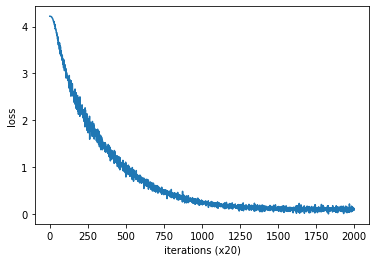

In [12]:
# 学習コードの実装

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'English has developed over the course of more than 1,400 years. The earliest forms of English, a group of West Germanic (Ingvaeonic) dialects brought to Great Britain by Anglo-Saxon settlers in the 5th century, are collectively called Old English. Middle English began in the late 11th century with the Norman conquest of England; this was a period in which English was influenced by Old French, in particular through its Old Norman dialect. Early Modern English began in the late 15th century with the introduction of the printing press to London, the printing of the King James Bible and the start of the Great Vowel Shift.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
print(vocab_size)
contexts, target = create_contexts_target(corpus, window_size)

target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [13]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

english [-0.315234   3.9086914 -2.3731754  0.287859   8.310104 ]
has [-0.63595426  1.7587581   5.0106034   5.1139884   4.070979  ]
developed [-7.035668   5.9560165 -3.0140936  1.5820165  5.2690196]
over [0.47416076 3.827623   4.764954   5.8805246  3.1383803 ]
the [-2.3074465 -1.9304731  5.474582  -6.527086  -2.5420697]
course [ 4.1667695 -3.2063088  2.2240314  2.9044297 -4.804574 ]
of [-3.5105188  2.2618628  3.1231246  6.591425  -5.217502 ]
more [ 5.6336613  0.5484412  4.2685437 -5.1469884 -5.7639785]
than [-6.5053725  6.662398  -6.1575856 -1.4973341 -2.5086186]
1,400 [ 5.9116254  6.2443924 -2.689034  -5.4080524 -6.784101 ]
years [ 1.1904523  2.1041458 -3.1392648 -5.2908206  5.6217713]
. [ 6.89696   -0.6223497 -6.411065   4.8773723 -3.3176687]
earliest [-3.6561983   0.9734866   5.2165966   4.01584     0.67216766]
forms [-1.2430884 -4.460794   5.4997    -2.4433568 -5.9603486]
english, [ 1.6801645  -6.2844853  -0.17067608  1.5559428   2.4361293 ]
a [-5.64522    8.637842   5.0512147 -3.43

同じように損失lossが徐々に減っている。

**skip-gramモデル**\
ターゲットからコンテキストを推論する手法。CBOWは2単語から1単語を導いていたのに対し、skip-gramは1単語から2単語を推論する

**CBOWとskip-gram**\
CBOWとskip-gramではskip-gramのほうが精度がよいが、CBOWのほうが実行速度が速い。これは計算量から明らかである。\
損失関数について、CBOWは一つのターゲットの損失を考えるが、skip-gramはコンテキスト全体の損失を考える。交差エントロピー誤差を用いることの利点に、skip-gramの損失の計算が積から和に変換できることがあげられる。

**カウントベースと推論ベースの比較**\
**新たな語彙の追加を考えるとき**\
カウントベースでは、追加するたびに全計算を行う\
推論ベースでは、重みの再学習を行うだけでよい\
**精度**\
カウントベースと推論ベースで精度の点で優劣が付けられない\

**参考文献**
1. ゼロから作る Deep Learning Pythonで学ぶディープランニングの理論と実装